### Welcome

This notebook is used for the accuracy assessment of modal filters. It uses data for Newcastle Upon Tyne. If you create your own manual classification of modal filters, you should be able to use this same code with minor adjustments!

In [229]:
# Library imports
import geopandas as gpd
import osmnx as ox
import networkx as nx
import momepy
from shapely import Polygon
import matplotlib.pyplot as plt
import folium
import pandas as pd
import overpy
from shapely.geometry import LineString
from shapely.geometry import Point
import requests
from itertools import product
from shapely.geometry import MultiPolygon

In [230]:
# update osmnx settings
useful_tags_ways = ox.settings.useful_tags_way + ['cycleway'] + ['bicycle'] + ['motor_vehicle'] + ['railway'] + ['tunnel'] + ['barrier'] + ['bus'] + ['access'] + ['oneway'] + ['oneway:bicycle'] + ['covered'] + ['waterway']
ox.config(use_cache=True, 
          log_console=True,
          useful_tags_way=useful_tags_ways
          )

C:\Users\b8008458\AppData\Local\Temp\ipykernel_29912\305956182.py:3: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(use_cache=True,


In [231]:
# set place
place = "Newcastle Upon Tyne, United Kingdom"

In [232]:
#  boundary

boundary = ox.geocode_to_gdf(place)
boundary = boundary.to_crs('EPSG:27700')

# buffer boundary to ensure clips include riverlines which may act as borders between geographies
boundary_buffered = boundary.buffer(50)


# plot boundary (always best to double check!)
boundary.explore()

In [233]:
## get street network for the study area

# get the boundary in the correct CRS for OSMnx
boundary_4326 = boundary.to_crs('EPSG:4326')

# OSM is used over OS datasets as OSM is better for non-driving streets
streets = ox.graph_from_polygon(boundary_4326.geometry.iloc[0], network_type='all')

# Convert the OSMnx graph to a GeoDataFrame of streets
streets_gdf = ox.graph_to_gdfs(streets, nodes=False, edges=True)

In [234]:
## get filters

tags = {"barrier": ["bollard", "bus_trap", "entrance", "planter", "sump_buster", "wedge"]}

## get barrier filters
# get the boundary in the correct CRS for OSMnx
boundary_4326 = boundary.to_crs('EPSG:4326')

# Use ox.features_from_polygon to find features matching the specified tags
barriers = ox.features_from_polygon(polygon = boundary_4326.geometry.iloc[0], tags = tags)




## process any linestrings into point geometries

# Filter the GeoDataFrame to select only rows with "linestring" geometry
barriers_linestrings = barriers[barriers['geometry'].geom_type == 'LineString']

# Create an empty GeoDataFrame to store the individual points
points_gdf = gpd.GeoDataFrame(columns=list(barriers_linestrings.columns), crs=barriers_linestrings.crs)

# Iterate through each row in the GeoDataFrame with linestrings
for idx, row in barriers_linestrings.iterrows():
    if isinstance(row['geometry'], LineString):
        # Extract the individual points from the linestring
        points = [Point(coord) for coord in list(row['geometry'].coords)]
        
        # Create a GeoDataFrame from the individual points and copy the attributes
        points_df = gpd.GeoDataFrame(geometry=points, crs=barriers_linestrings.crs)
        for col in barriers_linestrings.columns:
            if col != 'geometry':
                points_df[col] = row[col]
        
        # Rename the "geometry" column to "merged_geometry"
        points_df = points_df.rename(columns={'geometry': 'merged_geometry'})
        
        # Append the points to the points_gdf
        points_gdf = pd.concat([points_gdf, points_df], ignore_index=True)

# Now, points_gdf contains all the individual points from the linestrings with inherited attributes

# Remove the "geometry" column from the points GeoDataFrame
points_gdf = points_gdf.drop(columns=['geometry'])

# Remove the linestring rows from the original GeoDataFrame
barriers = barriers[barriers['geometry'].geom_type != 'LineString']

# Rename the "merged_geometry" column to "geometry" in the points GeoDataFrame
points_gdf = points_gdf.rename(columns={'merged_geometry': 'geometry'})

# Concatenate the individual points GeoDataFrame to the original GeoDataFrame
barriers = pd.concat([barriers, points_gdf], ignore_index=True)

# Reset the index to ensure it is continuous
barriers.reset_index(drop=True, inplace=True)

# Create a new column "previously_linestring" and set it to False initially
barriers['previously_linestring'] = False

# Iterate through each row in the GeoDataFrame with linestrings
for idx, row in barriers_linestrings.iterrows():
    if isinstance(row['geometry'], LineString):
        # Extract the individual points from the linestring
        points = [Point(coord) for coord in list(row['geometry'].coords)]
        
        # Iterate through the points in the linestring
        for point in points:
            # Check if the point's geometry intersects with any of the original linestrings
            mask = barriers['geometry'].intersects(point)
            if mask.any():
                # If the point intersects with any linestring, set "previously_linestring" to True
                barriers.loc[mask, 'previously_linestring'] = True

# add a unique ID
barriers['barrier_id'] = range(1, len(barriers) + 1)


# join the barriers to the streets 
streets_gdf = gpd.sjoin(streets_gdf, barriers, how = "left", op="intersects")

# clean geodataframe and drop streets without a barrier
streets_gdf.columns = streets_gdf.columns.str.replace("_right", "_barrier").str.replace("_left","_street")
# we need to double check the name of "barrier"
streets_gdf['barrier_barrier'] = streets_gdf['barrier'] if 'barrier' in streets_gdf.columns else streets_gdf['barrier_barrier']

if 'name_street' in streets_gdf.columns:
    streets_gdf = streets_gdf.rename(columns={'name_street': 'name'})
barrier_streets = streets_gdf.dropna(subset=['barrier_barrier'])

# add barrier tag
barrier_streets['filter_type'] = 'barrier or bollard'


## extract points which are on/within 1m of streets only
streets_gdf['has_barrier'] = 'yes'

# reset crs before spatail join
barriers, streets_gdf = barriers.to_crs(3857), streets_gdf.to_crs(3857)

barriers = gpd.sjoin_nearest(barriers, streets_gdf, how = "left", max_distance = 1)
barriers = barriers.dropna(subset=['has_barrier'])
barriers = barriers.reset_index(drop=True)  # Reset the index
# Dissolve based on the 'geometry' column

# re-reset crs 
barriers, streets_gdf = barriers.to_crs(4326), streets_gdf.to_crs(4326)

# we need to double check the name of "barrier_id"
import numpy as np
streets_gdf['barrier_id_right'] = streets_gdf['barrier_id'] if 'barrier_id' in streets_gdf.columns else streets_gdf['barrier_id_right']
# dissolve
barriers = barriers.dissolve(by='barrier_id_right')
# add barrier tag
barriers['filter_type'] = 'barrier or bollard'
# Reset the index to remove multi-index
barriers.reset_index(drop=True, inplace=True)

## get bus gates

# we need to double check the name of "access"
streets_gdf['access_street'] = streets_gdf['access'] if 'access' in streets_gdf.columns else streets_gdf['access_street']
streets_gdf['bicycle_street'] = streets_gdf['bicycle'] if 'bicycle' in streets_gdf.columns else streets_gdf['bicycle_street']
streets_gdf['bus'] = streets_gdf['bus_street'] if 'bus_street' in streets_gdf.columns else streets_gdf['bus']


busgates = streets_gdf[((streets_gdf["bus"] == "yes") & (streets_gdf["access_street"] == "no") & (streets_gdf["bicycle_street"] == "yes")) |
                    (streets_gdf["bus"] == "yes") & (streets_gdf["motor_vehicle_street"] == "no") & (streets_gdf["bicycle_street"] == "yes")
                    ]

# add bus gate tag
busgates['filter_type'] = 'bus gate'


## cycle contra-flows
oneways = streets_gdf[(streets_gdf["oneway"] == True) & (streets_gdf["oneway:bicycle"] == "no")]

# we dissolve the roads with the same name as to not miscount the total number of oneways
# Convert values in the "name" column to strings if they are not already
oneways['name'] = oneways['name'].apply(lambda x: ', '.join(map(str, x)) if isinstance(x, list) else str(x))

# Perform dissolve 
oneways = oneways.dissolve(by='name')

# Reset the index 
oneways = oneways.reset_index()



# add one way tag
oneways['filter_type'] = 'one-way bike'


## street continunations

def filter_streets_continuations(input_gdf):
    ## clean dataframe
    # Check if 'highway_street' column exists and rename it to 'highway'
    if 'highway_street' in input_gdf.columns:
        input_gdf.rename(columns={'highway_street': 'highway'}, inplace=True)




    # filter dataframe 
    ## remove indoor roads, these are likey pedestrian only however often don't have any "cycling" related tag
    if 'covered' in input_gdf.columns:
        input_gdf = input_gdf[~input_gdf['highway'].apply(lambda x: 'covered' in str(x))]
        input_gdf = input_gdf[input_gdf['covered'] != 'yes']
    ## also remove footways and steps, as these are almost pedestrain only, never cyclable
    input_gdf = input_gdf[~input_gdf['highway'].apply(lambda x: 'footway' in str(x))]
    input_gdf = input_gdf[~input_gdf['highway'].apply(lambda x: 'steps' in str(x))]



    ## clean dataframe
    input_gdf['name'] = input_gdf['name'].apply(lambda x: ', '.join(map(str, x)) if isinstance(x, list) else str(x))
    input_gdf['highway'] = input_gdf['highway'].apply(lambda x: ', '.join(map(str, x)) if isinstance(x, list) else str(x))




    ## perform street continunation filtering
    # Grouping by 'name' and checking for groups with 'pedestrian' and another highway type
    grouped = input_gdf.groupby('name').filter(lambda x: any('pedestrian' in val for val in x['highway']) and len(x['highway'].unique()) > 1)
    street_continuations_gdf = grouped[grouped['highway'].str.contains('pedestrian', case=False, na=False)] # Extracting the rows containing 'pedestrian' in the highway column

    ## deal with nan names


    ## dissolve lines that are very very close to each other
    if not street_continuations_gdf.empty:
        street_continuations_gdf = street_continuations_gdf.to_crs('27700')
        street_continuations_gdf['buffer'] = street_continuations_gdf.geometry.buffer(1)
        dissolved = street_continuations_gdf.dissolve(by='name')
        
        # If a MultiPolygon is formed, convert it to individual polygons
        if isinstance(dissolved.geometry.iloc[0], MultiPolygon):
            dissolved = dissolved.explode()
        
        # Remove the buffer column
        dissolved = dissolved.drop(columns='buffer')
        street_continuations_gdf = dissolved.to_crs('4326')

    return street_continuations_gdf



# get street continunations
streets_continuations_gdf = filter_streets_continuations(streets_gdf)

# add street conitinuation tag
streets_continuations_gdf['filter_type'] = 'street continuation'


# join filters
filters = gpd.GeoDataFrame(pd.concat([barriers, busgates, oneways, streets_continuations_gdf], ignore_index=True))

c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

In [235]:
## optionally read in cyclestreets filters

cs_filters = gpd.read_file(r'C:\Users\b8008458\Documents\scratch_space\CS_Filters.gpkg')

# set column name to match with our names
# Define a mapping dictionary
mapping_dict = {
    'bollard': 'barrier or bollard',
    'gap': 'street continuation',
    'gate': 'street continuation',
    'cycleway filter': 'one-way bike'
}

# Update the values in the "modalfilter" column
cs_filters['modalfilter'] = cs_filters['modalfilter'].map(mapping_dict).fillna(cs_filters['modalfilter'])

# rename header
cs_filters = cs_filters.rename(columns={'modalfilter': 'filter_type'})

# drop unneeded columns
cs_filters = cs_filters[['geometry', 'filter_type']]

# clip to area
cs_filters = gpd.clip(cs_filters, boundary.geometry)

auto_filters = cs_filters

In [236]:
## read in manually classified points and lines


# Load manually classified lines and points
manual_lines = gpd.read_file(r'C:\Users\b8008458\OneDrive - Newcastle University\2022 to 2023\PhD\ltnDetection\LTN-Detection\data\manual_classification_modal_filter_lines.gpkg')
manual_points = gpd.read_file(r'C:\Users\b8008458\OneDrive - Newcastle University\2022 to 2023\PhD\ltnDetection\LTN-Detection\data\manual_classification_modal_filter_points.gpkg')

## change crs to BNG

manual_lines = manual_lines.to_crs(27700)
manual_points = manual_points.to_crs(27700)
auto_filters = filters.to_crs(27700)

#manual_filters = gpd.GeoDataFrame(pd.concat([manual_lines, manual_points], ignore_index=True))

## clean gdfs
# Remove all columns except 'geometry' and 'filter_type' from auto_lines
auto_filters = auto_filters[['geometry', 'filter_type']]




## preprocessing of manual points
manual_points['Barrier'] = True

manual_filters = gpd.GeoDataFrame(pd.concat([manual_lines, manual_points], ignore_index=True))

# Rename the column headers
manual_filters.rename(columns={
    'bus_gate': 'bus gate',
    'street_continuation': 'street continuation',
    'contra_flow': 'one-way bike',
    'Barrier': 'barrier or bollard'
}, inplace=True)

columns_to_combine = ["bus gate", "one-way bike", "street continuation", "barrier or bollard"]

# Melt the specified columns into a new DataFrame
melted_manual_filters = pd.melt(manual_filters, id_vars=['geometry'], value_vars=columns_to_combine, var_name='filter_type', value_name='filter_value')

# Drop rows where filter_value is False or NaN
melted_manual_filters = melted_manual_filters[melted_manual_filters['filter_value'].notna() & melted_manual_filters['filter_value']]

# Group by geometry and concatenate filter types
combined_filter_types = melted_manual_filters.groupby('geometry')['filter_type'].apply(list).reset_index()

# Merge combined_filter_types back to manual_filters based on geometry
manual_filters = manual_filters.merge(combined_filter_types, on='geometry', how='left')


manual_filters['filter_type'] = manual_filters['filter_type'].apply(lambda x: ', '.join(x))

# clean gdf
manual_filters.drop(columns=['bus gate', 'one-way bike', 'street continuation', 'barrier or bollard'], inplace=True)




In [237]:
## Buffer manual lines by 10 meters and preserve the filter type
buffered_manual_geometries = [geom.buffer(10) for geom in manual_filters['geometry']]
buffered_manual_filters = gpd.GeoDataFrame(geometry=buffered_manual_geometries, crs=manual_filters.crs)
buffered_manual_filters['filter_type'] = manual_filters['filter_type']

## Testing code - Remove later

In [240]:
## clip filters to a tiny area

# Create a bounding box geometry
bbox = box(-1.6198, 54.9747, -1.6135, 54.9810)
# Create a GeoDataFrame from the bounding box
bounding_box_gdf = gpd.GeoDataFrame(geometry=[bbox], crs='EPSG:4326')
bounding_box_gdf = bounding_box_gdf.to_crs(27700)

man = gpd.clip(buffered_manual_filters, bounding_box_gdf)
auto = gpd.clip(auto_filters, bounding_box_gdf)

# ensure matching geometries
auto['geometry'] = auto.geometry.buffer(1)



## End of Testing code - Remove later

In [247]:
man = buffered_manual_filters
auto = auto_filters

In [248]:



# Perform spatial join to find the overlapping geometries
overlap = gpd.sjoin(man, auto, how="inner", op='intersects')

# Group overlapping geometries by their index in the "auto" GeoDataFrame and count occurrences
overlap_counts = overlap.groupby('index_right').size()

# Filter out instances where there are multiple overlapping geometries
filtered_overlap_counts = overlap_counts[overlap_counts == 1]

# Calculate the count and percentage of overlapping geometries
total_overlap_count = len(filtered_overlap_counts)



## find missed manual filters
#Perform a left spatial join to find the geometries in "man" that do not overlap with any geometries in "auto"
opposite_overlap = gpd.sjoin(man, auto, how="left", op='intersects')

# Filter out the rows where the geometry from "man" does not have a corresponding geometry from "auto"
missed_man = opposite_overlap[opposite_overlap['index_right'].isna()]
missed_man_percentage = (len(missed_man) / len(man)) * 100
overlap_percentage = 100 - missed_man_percentage


print("Count of overlapping geometries between man and auto:", total_overlap_count, "with", len(man), "manual filters and", len(auto), "auto detected filters")
print("Percentage of overlap between man and auto:", overlap_percentage)
print("Missed manual filters = ", missed_man_percentage,"%")

Count of overlapping geometries between man and auto: 156 with 424 manual filters and 322 auto detected filters
Percentage of overlap between man and auto: 77.12264150943396
Missed manual filters =  22.87735849056604 %


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


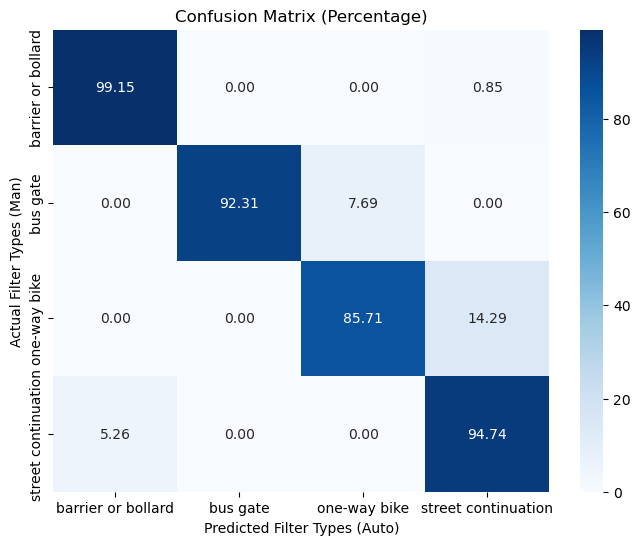

In [249]:
import geopandas as gpd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming you have GeoDataFrames called "man" and "auto"

# Perform spatial join to find the overlapping geometries
overlap = gpd.sjoin(man, auto, how="inner", op='intersects')

# Filter out instances where there are multiple overlapping geometries
filtered_overlap = overlap.groupby('index_right').filter(lambda x: len(x) == 1)

# Get the filter_type values for the filtered_overlap
man_filter_types = filtered_overlap['filter_type_left']
auto_filter_types = filtered_overlap['filter_type_right']

# Create a confusion matrix
conf_matrix = confusion_matrix(man_filter_types, auto_filter_types, labels=['barrier or bollard', 'bus gate', 'one-way bike', 'street continuation'])

# Normalize the confusion matrix to get percentages
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['barrier or bollard', 'bus gate', 'one-way bike', 'street continuation'], 
            yticklabels=['barrier or bollard', 'bus gate', 'one-way bike', 'street continuation'])
plt.xlabel('Predicted Filter Types (Auto)')
plt.ylabel('Actual Filter Types (Man)')
plt.title('Confusion Matrix (Percentage)')
plt.show()


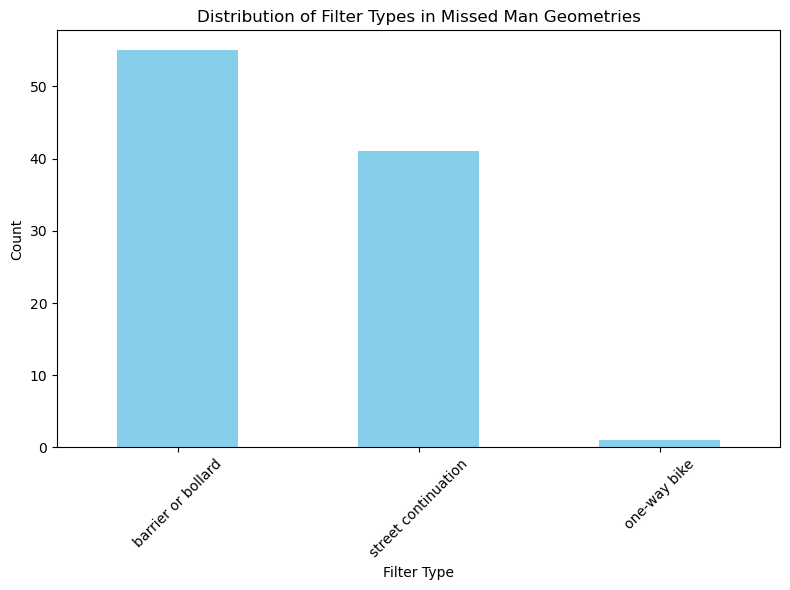

In [250]:
import matplotlib.pyplot as plt


# Plot the distribution of "filter_type" from the missed_man DataFrame
plt.figure(figsize=(8, 6))
missed_man['filter_type_left'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Filter Type')
plt.ylabel('Count')
plt.title('Distribution of Filter Types in Missed Man Geometries')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()


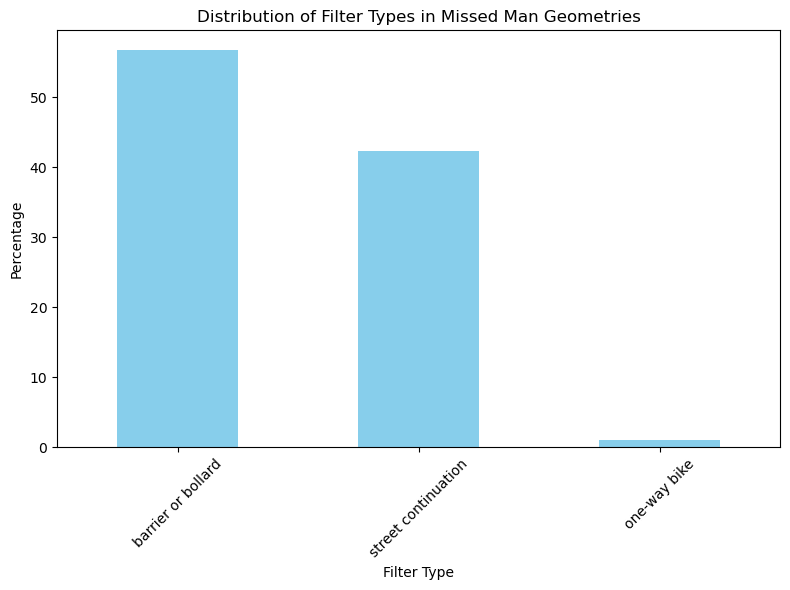

In [252]:
import matplotlib.pyplot as plt

# Assuming you have already obtained the "missed_man" DataFrame

# Calculate the total number of missed "man" geometries
total_missed_man = len(missed_man)

# Calculate the percentage of each filter type
filter_type_percentage = (missed_man['filter_type_left'].value_counts() / total_missed_man) * 100

# Plot the distribution of "filter_type" from the missed_man DataFrame as percentages
plt.figure(figsize=(8, 6))
filter_type_percentage.plot(kind='bar', color='skyblue')
plt.xlabel('Filter Type')
plt.ylabel('Percentage')
plt.title('Distribution of Filter Types in Missed Man Geometries')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()
